<a href="https://colab.research.google.com/github/nichanankhantha/229351-StatLearningforDatasci1/blob/main/229351-LAB06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ปฏิบัติการครั้งที่ 6 กระบวนวิชา 229351 Statistical Learning for Data Science

คำชี้แจง

ให้เริ่มทำปฏิบัติการจาก colab notebook ที่กำหนดให้ จากนั้น share แล้วส่ง link มาใน mango.cmu.ac.th

ดาวน์โหลดข้อมูลรถยนต์ชนิดต่างใน link ข้างล่างนี้
https://donlapark.pages.dev/229351/data/Auto.csv
หรือรันโค้ดข้างล่าง

In [ ]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# StatsModels
!pip install statsmodels --quiet
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Download the file
!wget https://donlapark.pages.dev/229351/data/Auto.csv

In [ ]:
# อ่านไฟล์ csv ก่อนเพื่อหา missing values
auto = pd.read_csv('Auto.csv', na_values=["?"])

# ลบแถวที่มี missing values
auto = auto.dropna()

auto = auto.drop(['name', 'origin'],axis=1)

auto.head()

# Linear model diagnosis

In [ ]:
# simple linear regression on Auto dataset
auto_lr = smf.ols('mpg ~ horsepower ', data=auto).fit()
print(auto_lr.summary())

### คำนวณ Residuals $y_i-\hat{y}_i$

In [ ]:
#Fitted values
auto_fitted = auto_lr.predict(auto)

#Residuals
auto_res = auto['mpg']-auto_fitted

print(auto_res)

### หรือสามารถดึง predictions และ residuals จากโมเดลได้โดยตรง

In [ ]:
# Fitted values
auto_fitted_ = auto_lr.fittedvalues

# Residuals
auto_res_ = auto_lr.resid

### 1. ทดสอบ non-linearity

In [ ]:
plt.scatter(auto_fitted, auto_res)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');

In [ ]:
plt.scatter(auto_lr.fittedvalues, auto_lr.resid)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');

print(auto_lr.fittedvalues)

In [ ]:
auto_lr2 = smf.ols('mpg ~ horsepower+I(horsepower**2)', data=auto).fit()
print(auto_lr2.summary())

In [ ]:
plt.scatter(auto_lr2.fittedvalues, auto_lr2.resid)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');

### 2. ทดสอบ independence of errors
2.1 ตรวจสอบโดยการ plot time vs residuals (ถ้าสามารถทำได้)

2.2 ตรวจสอบด้วย Durbin-Wutson test  

H0: There is no correlation among the residuals.  
H1: The residuals are correlated.

The Durbin-Watson statistic ranges in value from 0
to 4. A value near 2 indicates non-correlation; a value toward 0 indicates positive
correlation; a value toward 4 indicates negative correlation.

Reject H0 if d < dL  
Accept H0 if d > dU

Durbin-Watson table: https://www.real-statistics.com/statistics-tables/durbin-watson-table/

In [ ]:
auto_lr2 = smf.ols('mpg ~ horsepower+I(horsepower**2)', data=auto).fit()
print(auto_lr2.summary())

### ดูตาราง Durbin-Watson Alpha = .05 n = 350 และ k = 2

ได้ค่า dL = 1.813 dU = 1.836

ดังนั้น Reject H0 -- มี correlation ระหว่าง residuals

### 3. ทดสอบ constant variance

### ใช้ Breush-Pagan test


H0: The residuals are distributed with equal variance  
H1: The residuals are not distributed with equal variance


In [ ]:
import statsmodels.stats.api as sms

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(auto_lr2.resid, auto_lr2.model.exog)
pd.DataFrame({'Name':name, 'value':test})

### p-value < 0.05 ดังนั้น accept H1

In [ ]:
auto_lr3 = smf.ols('I(np.log(mpg)) ~ horsepower+I(horsepower**2)', data=auto).fit()
print(auto_lr3.summary())

In [ ]:
plt.scatter(auto_lr3.fittedvalues, auto_lr3.resid)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');

### ลอง Breush-Pagan test อีกครั้ง

In [ ]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(auto_lr3.resid, auto_lr3.model.exog)
pd.DataFrame({'Name':name, 'value':test})

### p-value ฬ 0.05 ดังนั้น accept Hจ

### 4., 5. หา outliers และ leverage points

In [ ]:
import statsmodels.graphics.api as smg

smg.influence_plot(auto_lr2, size=10)

#Cook's distance line ที่ระดับ 0.5
p = 1 # จำนวนตัวแปรต้น
x = np.linspace(0.01, 0.1, 50)
plt.plot(x, np.sqrt(0.5*p*(1 - x)/x), color='red', linestyle='dashed')

plt.xlim(0,0.1)
plt.xlabel('Leverage')
plt.ylabel('Standardized residuals')
plt.title('Residuals vs Leverage');

### 6. ทดสอบ multicollinearity

ลบตัวแปรที่มีค่า VIF > 10

In [ ]:
print(auto_lr3.model.exog)  # matrix of exogenous variables

In [ ]:
print(auto_lr3.model.exog_names)  # names of exogenous variables

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

auto_lr4 = smf.ols('I(np.log(mpg)) ~ cylinders \
                                     + displacement \
                                     + horsepower \
                                     + weight \
                                     + acceleration', data=auto).fit()

exog = auto_lr4.model.exog
exog_names = auto_lr4.model.exog_names

for i in range(1,len(exog_names)):
    print(exog_names[i], vif(exog, i))

### Exercise

ดาวน์โหลดข้อมูลรถยนต์ชนิดต่างใน link ข้างล่างนี้
https://donlapark.pages.dev/229351/data/Carseats.csv
หรือรันโค้ดข้างล่าง

In [ ]:
# Download the file
!wget https://donlapark.pages.dev/229351/data/Carseats.csv


Sales

    Unit sales (in thousands) at each location
CompPrice

    Price charged by competitor at each location
Income

    Community income level (in thousands of dollars)
Advertising

    Local advertising budget for company at each location (in thousands of dollars)
Population

    Population size in region (in thousands)
Price

    Price company charges for car seats at each site
ShelveLoc

    A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
Age

    Average age of the local population
Education

    Education level at each location
Urban

    A factor with levels No and Yes to indicate whether the store is in an urban or rural location
US

    A factor with levels No and Yes to indicate whether the store is in the US or not

In [ ]:
# อ่านไฟล์ csv ก่อนเพื่อหา missing values
carseats = pd.read_csv('Carseats.csv')

carseats.head()

In [ ]:
all_predictors = '+'.join(carseats.columns.drop('Sales')) #ใช้สูตร 'Sales ~' + all_predictors ในการสร้างโมเดล

'Sales ~ ' + all_predictors

### Bad = Intercept + other values
### Medium = Intercept + other values + ShelveLoc(Med)*1
### Good = Intercept + other values + ShelveLoc(Good)*1

###จงสร้าง residual plot และ influence plot แล้วตอบคำถามต่อไปนี้

1. สมมติว่าตัวแปรอื่นมีค่าเท่ากัน โดยเฉลี่ยแล้ว ยอดขายของเบาะรถที่วางบนชั้นที่มีคุณภาพปานกลาง (ShelveLoc (Medium)) กับชั้นที่มีคุณภาพต่ำ (ShelveLoc (Bad)) ต่างกันอย่างไร ต่างกันเท่าไหร่
2. สมมติว่าตัวแปรอื่นมีค่าเท่ากัน โดยเฉลี่ยแล้ว ยอดขายของเบาะรถที่วางบนชั้นที่มีคุณภาพดี (ShelveLoc (Good)) กับชั้นที่มีคุณภาพปานกลาง (ShelveLoc (Medium)) ต่างกันอย่างไร ต่างกันเท่าไหร่
3. จงตรวจสอบว่าข้อมูลที่ใช้มีความเหมาะสมกับการสร้าง linear regression หรือไม่ โดยพิจารณาสิ่งต่างๆเหล่านี้พร้อมกับให้เหตุผล  
  3.1 Non-linearity  
  3.2 Independence of errors  
  3.3 Constant variance  
  3.4 Outliers  
  3.5 Leverage points  
  3.6 Multicollinearity


In [22]:
# อ่านไฟล์ csv ก่อนเพื่อหา missing values
auto = pd.read_csv('Carseats.csv', na_values=["?"])

# ลบแถวที่มี missing values
auto = auto.dropna()

auto.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [23]:
# simple linear regression on Auto dataset
auto_lr = smf.ols('Sales ~ ShelveLoc ', data=auto).fit()
print(auto_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     92.23
Date:                Tue, 19 Aug 2025   Prob (F-statistic):           1.27e-33
Time:                        16:52:42   Log-Likelihood:                -906.03
No. Observations:                 400   AIC:                             1818.
Df Residuals:                     397   BIC:                             1830.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.5229    

ตอบ
1. Mediam has 1.7837 more sales than Bad
2. Good has 2.9074 more sales than Mediam

In [24]:
#Fitted values
auto_fitted = auto_lr.predict(auto)

#Residuals
auto_res = auto['Sales']-auto_fitted

print(auto_res)

0      3.977083
1      1.006000
2      2.753425
3      0.093425
4     -1.372917
         ...   
395    2.356000
396   -1.166575
397    0.103425
398    0.417083
399   -0.504000
Length: 400, dtype: float64


In [26]:
# Fitted values
auto_fitted_ = auto_lr.fittedvalues

# Residuals
auto_res_ = auto_lr.resid

3.1 Non-linearity

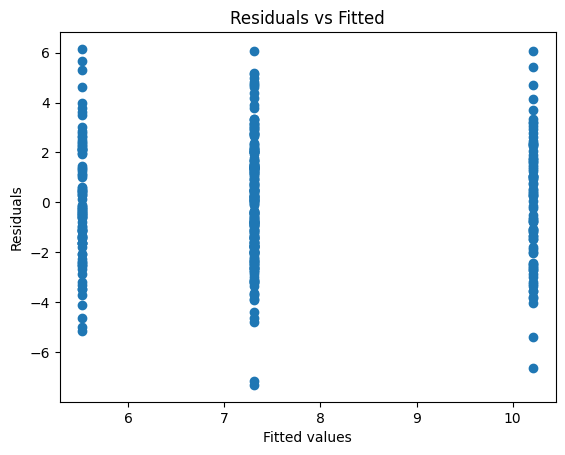

In [27]:
plt.scatter(auto_fitted, auto_res)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');

0       5.522917
1      10.214000
2       7.306575
3       7.306575
4       5.522917
         ...    
395    10.214000
396     7.306575
397     7.306575
398     5.522917
399    10.214000
Length: 400, dtype: float64


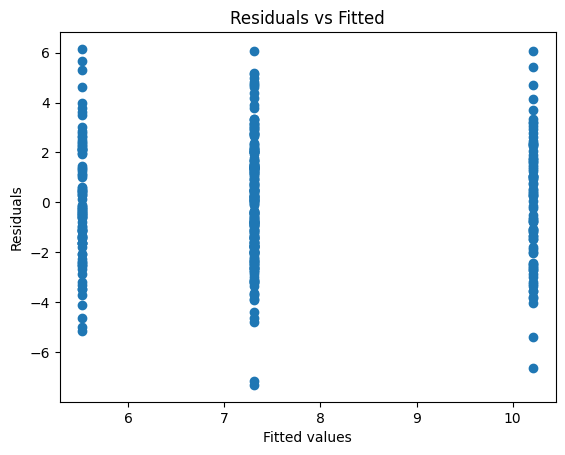

In [28]:
plt.scatter(auto_lr.fittedvalues, auto_lr.resid)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');

print(auto_lr.fittedvalues)

3.2 Independence of errors

3.3 Constant variance

3.4 Outliers

3.5 Leverage points

3.6 Multicollinearity